# Chest X-Ray Images (Pneumonia) Classification

### Introduction
By Ziv Ben Zvi 203966643 and Julian Rubinstein 204907901.

Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.
Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases. Diagnosis is often based on symptoms and physical examination. Chest X-rays, blood tests, and culture of the sputum may help confirm the diagnosis.

As mentioned above, a chest X-ray is a prominent and common way to identify pneumonia. Therefore, developing an accurate model for analyzing the results of a chest X-ray can be extremly helpful in succesfuly diagnosing pneumonia in patients. The following paper will discuss the development of such model and its subsuquent accuracy and efficacy in acomplishing this task. The learning proccess of this model uses the dataset provided in the kaggle competition [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/discussion) and will attempt to classify X-ray lung images to either normal or pneumonia. The dataset contains 5,840 chest X-Ray RGB images (JPEG) divided into NORMAL or PNEUMONIA folders.

<img src="Inkedindex_LI.jpg">

### Imports

In [115]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm.auto import tqdm
import cv2

In [116]:
import sklearn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

### Loading Data and Data Processing

We define the data paths, compress the images by resizing them and then load the data to a list of 2d np arrays which represnt the images:

In [117]:
#NORMAL_PATH = 'F:\Dropbox\Studies\Computer Science\DSseminar\DSFinalProject\Spyder\chest_xray/DATA/NORMAL'
#PNEUMONIA_PATH = 'F:\Dropbox\Studies\Computer Science\DSseminar\DSFinalProject\Spyder\chest_xray/DATA/PNEUMONIA'
NORMAL_PATH = 'chest_xray/DATA/NORMAL'
PNEUMONIA_PATH = 'chest_xray/DATA/PNEUMONIA'

NORMAL_FILES = glob(NORMAL_PATH + "/*.jpeg")
PNEUMONIA_FILES = glob(PNEUMONIA_PATH + "/*.jpeg")

normal_data = []
pneumonia_data = []

for file in tqdm(NORMAL_FILES):
    image = cv2.imread(file)
    image = cv2.resize(image, (100,60))
    normal_data.append(image)

for file in tqdm(PNEUMONIA_FILES):
    image = cv2.imread(file)
    image = cv2.resize(image, (100,60))
    pneumonia_data.append(image)

  0%|          | 0/1575 [00:00<?, ?it/s]

  0%|          | 0/4265 [00:00<?, ?it/s]

Let's print the size of both datasets and the shapes of the images:

### ORB - edge detection method

ORB stands for Oriented FAST and Rotated BRIEF, which are two algorithms used for feature extraction from an image. For our needs we will focus on the FAST method of The ORB algorithm, which means edge detection in an image. Our definition of an edge is as follow:<br>
Given a pixel p of a 2D image, the algorithm compares the value of p to his surrounding 16 pixels that are in a circle around him. The pixel's value stands for brightness. The pixels surrounding p is then sorted into three categories:
- Lighter than p
- Darker than p 
- Similar to p

In case of more than 8 pixels are brighter or darker than p, the pixel p is selected as a keypoint. Keypoints calculated by ORB algorithm gives us information of the location of determining edges in an image.<br>For our use, we would like to compare the amount of keypoints founded by ORB in normal and pneumonia images. Many keypoints will stand for high contrast between neighbour pixels in an image, where few keypoints will present low contrast between neighbour pixels.

In [111]:
orb = cv2.ORB_create(edgeThreshold=15,
                     patchSize=31,
                     nlevels=8,
                     fastThreshold=20,
                     scaleFactor=1.2,
                     WTA_K=2,
                     scoreType=cv2.ORB_HARRIS_SCORE,
                     firstLevel=0,
                     nfeatures=250)

In [112]:
normal_orb_data = []
pneumonia_orb_data = []

for image in normal_data:
    normal_orb_data.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    
for image in pneumonia_data:
    pneumonia_orb_data.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

In [113]:
normal_orb_keypoints = []
pneumonia_orb_keypoints = []

for image in normal_orb_data:
    keypoint, desc = orb.detectAndCompute(image,None)
    normal_orb_keypoints.append(len(keypoint))
    
for image in pneumonia_orb_data:
    keypoint, desc = orb.detectAndCompute(image,None)
    pneumonia_orb_keypoints.append(len(keypoint))

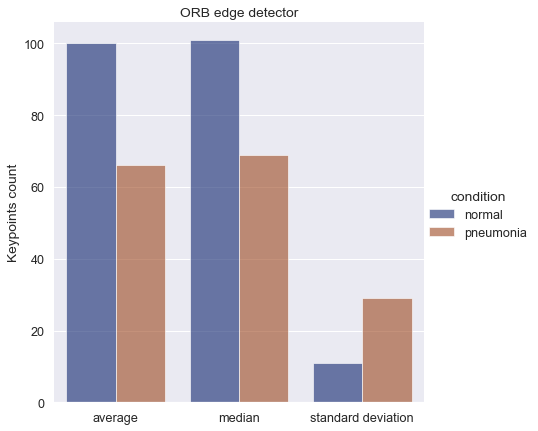

In [114]:
normal_mean = int(np.mean(normal_orb_keypoints))
pneumonia_mean = int(np.mean(pneumonia_orb_keypoints))

normal_median = int(np.median(normal_orb_keypoints))
pneumonia_median = int(np.median(pneumonia_orb_keypoints))

normal_std = int(np.std(normal_orb_keypoints))
pneumonia_std = int(np.std(pneumonia_orb_keypoints))
    
df  = pd.DataFrame({"method" : ["average", "average", "median", "median", "standard deviation", "standard deviation"],
                    "value" : [normal_mean, pneumonia_mean, normal_median, pneumonia_median, normal_std, pneumonia_std],
                    "condition" : ["normal", "pneumonia", "normal", "pneumonia", "normal", "pneumonia"]},
                    index = [1, 2, 3, 4, 5, 6])

plt.rcParams["figure.figsize"] = (15,7)
plot = sns.catplot(
        data=df, kind="bar",
        x="method", y="value", hue="condition", 
        ci="None", palette="dark", alpha=.6, height=6
    )
plot.despine(left=True)
plot.set_axis_labels("", "Keypoints count")
plt.title("ORB edge detector")    
sns.set(font_scale=1.15)

As seen the normal images seems to have a more contrast between neighbour pixels, which means we are more likely to see dark and bright parts in a given normal image, while on pneumonia images we will probably observe monotonous brightness level.